<a href="https://colab.research.google.com/github/rdkworld/AIPND-2022/blob/main/Generalized/Train_an_Existing_Pytorch_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train Pre-trained models on Custom Datasets

##Pre-requisite Setup

### User Input Parameters including Hyperparameters

In [ ]:
#Data
SOURCE_URL = 'https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz'
BASE_DIRECTORY = 'flowers'
DATA_DIRECTORY = 'data'
MODEL_DIRECTORY = 'models'
FILE_NAME = 'flowers.tar.gz'

# Setup hyperparameters
NUM_EPOCHS = 5
BATCH_SIZE = 64
HIDDEN_UNITS = '' #Not used for pretrained
LEARNING_RATE = 0.003
MODEL_NAME = 'vit_b_16'
MODEL_WEIGHT = 'ViT_B_16' 
LOSS_FUNCTION = 'CrossEntropyLoss'
OPTIMIZER = 'Adam'
MANUAL_RESIZE = 64 #Not used
NUM_CLASSES = 102
FEATURE_EXTRACT = True
RGB = 3 #(Color picture is 3, black & white is 1)

###Get Libraries

In [ ]:
# Install atleast torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 1.12.1+cu113
torchvision version: 0.13.1+cu113


###Regular Imports

In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

#Additions from functions
import os
import sys
import tarfile
from pathlib import Path

[INFO] Couldn't find torchinfo... installing it.


###Helpers/functions from Github

In [ ]:
# Try to import the helper functions, download it from GitHub if it doesn't work
try:
    import data_setup, engine, model_builder, utils 
    from helper_functions import download_data, set_seeds, plot_loss_curves, create_directory  
    from predictions import pred_and_plot_image
except:
    # Get the scripts
    print("[INFO] Couldn't find the scripts... downloading them from GitHub.")
    !git clone https://github.com/rdkworld/AIPND-2022
    #create_directory(Path().absolute() / BASE_DIRECTORY)
    !mkdir --parents /content/$BASE_DIRECTORY 
    !mv AIPND-2022/Generalized/*.py /content/$BASE_DIRECTORY
    !rm -rf AIPND-2022
    sys.path.append(os.path.join(os.getcwd(), BASE_DIRECTORY))
    import data_setup, engine, model_builder, utils 
    from helper_functions import download_data, set_seeds, plot_loss_curves, create_directory
    from predictions import pred_and_plot_image

In [ ]:
#Create Directory Structure
create_directory(Path(BASE_DIRECTORY))
create_directory(Path(BASE_DIRECTORY) / DATA_DIRECTORY)
create_directory(Path(BASE_DIRECTORY) / MODEL_DIRECTORY)

train_dir = f"{BASE_DIRECTORY}/{DATA_DIRECTORY}/{BASE_DIRECTORY}/train"
valid_dir = f"{BASE_DIRECTORY}/{DATA_DIRECTORY}/{BASE_DIRECTORY}/valid"
test_dir = f"{BASE_DIRECTORY}/{DATA_DIRECTORY}/{BASE_DIRECTORY}/test"

### Connect Colab and Google Drive to save and load models

In [ ]:
#Mount Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Setup target device

In [ ]:
# Setup target device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

##Download data and categorize into train/valid/test folders as required

In [ ]:
#Work in Progress, See next cell as a temporary measure

In [ ]:
#Temporarily copy from Google Drive
!cp /content/drive/MyDrive/flowers.tar.gz $BASE_DIRECTORY/$DATA_DIRECTORY #copy from drive to colab

In [ ]:
#Temporarily comment
#!tar xf $BASE_DATA_DIRECTORY/$FILE_NAME

## Ignore below errors, data is getting unzipped, need to figure out to remove the error though

In [ ]:
#Untar the file
#with tarfile.open(os.path.join(BASE_DIRECTORY, DATA_DIRECTORY, FILE_NAME), "r") as tar_ref:
with tarfile.open(Path(BASE_DIRECTORY) / DATA_DIRECTORY / FILE_NAME, "r") as tar_ref:
    print(f"[INFO] Unzipping {FILE_NAME}...") 
    tar_ref.extractall(Path(BASE_DIRECTORY) / DATA_DIRECTORY)

[INFO] Unzipping flowers.tar.gz...


EOFError: ignored

In [ ]:
if (Path(BASE_DIRECTORY) / DATA_DIRECTORY / FILE_NAME).is_file():
  (Path(BASE_DIRECTORY) / DATA_DIRECTORY / FILE_NAME).unlink()

## Get info on Pre-Trained Models

###Pre-trained Model & Transform Details

In [ ]:
#Get pre-trained model weights and model
pretrained_weights = eval(f"torchvision.models.{MODEL_WEIGHT}_Weights.DEFAULT")
pretrained_model = eval(f"torchvision.models.{MODEL_NAME}(weights = pretrained_weights)").to(device)
auto_transforms = pretrained_weights.transforms()

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

In [ ]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_model,
        input_size= (BATCH_SIZE, RGB, auto_transforms.crop_size[0], auto_transforms.crop_size[0]),  # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],  # col_names=["input_size"], # uncomment for smaller output
        col_width=20,
        row_settings=["var_names"]
), auto_transforms

(======================================================================================================================================================
 Layer (type (var_name))                                                Input Shape          Output Shape         Param #              Trainable
 VisionTransformer (VisionTransformer)                                  [64, 3, 224, 224]    [64, 1000]           768                  True
 ├─Conv2d (conv_proj)                                                   [64, 3, 224, 224]    [64, 768, 14, 14]    590,592              True
 ├─Encoder (encoder)                                                    [64, 197, 768]       [64, 197, 768]       151,296              True
 │    └─Dropout (dropout)                                               [64, 197, 768]       [64, 197, 768]       --                   --
 │    └─Sequential (layers)                                             [64, 197, 768]       [64, 197, 768]       --                   True
 │   

In [ ]:
# Create model with help from model_builder.py
updated_pretrained_model = model_builder.update_last_layer_pretrained_model(pretrained_model, NUM_CLASSES, FEATURE_EXTRACT).to(device)

In [ ]:
summary(model=updated_pretrained_model,
        input_size= (BATCH_SIZE, RGB, auto_transforms.crop_size[0], auto_transforms.crop_size[0]),  # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],  # col_names=["input_size"], # uncomment for smaller output
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                                Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                                  [64, 3, 224, 224]    [64, 102]            768                  Partial
├─Conv2d (conv_proj)                                                   [64, 3, 224, 224]    [64, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                                    [64, 197, 768]       [64, 197, 768]       151,296              False
│    └─Dropout (dropout)                                               [64, 197, 768]       [64, 197, 768]       --                   --
│    └─Sequential (layers)                                             [64, 197, 768]       [64, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                             [64, 197, 768]       [64, 197, 768]       (7,087,872)          False
│    │    └─Encod

###Dataloaders

In [ ]:
# Create data loaders
train_dataloader, test_dataloader, class_names, class_to_idx = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=auto_transforms,
    batch_size=BATCH_SIZE
)
if len(class_names) != NUM_CLASSES:
  print("Mismatch in the number of unique classes/labels and user input NUM_CLASSES")
  exit()

###Set loss and optimizer

In [ ]:
loss_fn = eval(f"torch.nn.{LOSS_FUNCTION}()")
optimizer = eval(f"torch.optim.{OPTIMIZER}(updated_pretrained_model.parameters(),lr=LEARNING_RATE)")

###Do the training

In [ ]:
# Start training with help from engine.py
pretrained_model_results = engine.train(model=updated_pretrained_model,
             train_dataloader=train_dataloader,
             test_dataloader=test_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             epochs=NUM_EPOCHS,
             device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1296 | train_acc: 0.9847 | test_loss: 0.2694 | test_acc: 0.9383
Epoch: 2 | train_loss: 0.0770 | train_acc: 0.9948 | test_loss: 0.2340 | test_acc: 0.9402
Epoch: 3 | train_loss: 0.0495 | train_acc: 0.9980 | test_loss: 0.2185 | test_acc: 0.9402
Epoch: 4 | train_loss: 0.0363 | train_acc: 0.9988 | test_loss: 0.2111 | test_acc: 0.9495
Epoch: 5 | train_loss: 0.0263 | train_acc: 0.9998 | test_loss: 0.1850 | test_acc: 0.9504


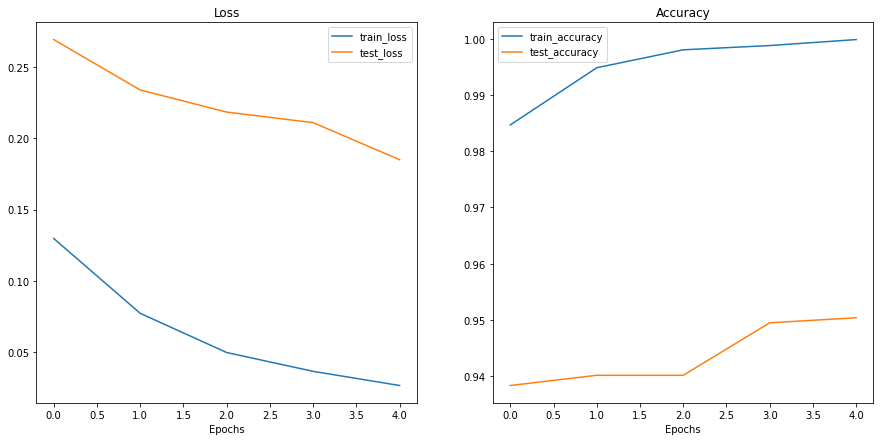

In [ ]:
#Plot the results/loss curves
plot_loss_curves(pretrained_model_results)

###Save the model



In [ ]:
checkpoint = {'state_dict': updated_pretrained_model.state_dict(),
              'arch': MODEL_NAME,
              'arch_weight': MODEL_WEIGHT,              
              'arch_type': 'EXISTING',
              'loss_function': LOSS_FUNCTION,
              'optimizer': OPTIMIZER,                            
              'class_names' : class_names,
              'class_to_idx' : class_to_idx,
              'hidden_units': HIDDEN_UNITS,
              'num_classes' : NUM_CLASSES,
              'feature_extract' : FEATURE_EXTRACT,
              'gpu_or_cpu' : device
             }

In [ ]:
# Save the model on local drive
utils.save_model(model=updated_pretrained_model, target_dir=f"{BASE_DIRECTORY}/{MODEL_DIRECTORY}", model_name=f"{MODEL_NAME}_model.pth", checkpoint = checkpoint)

[INFO] Saving model to: flowers/models/vit_b_16_model.pth


In [ ]:
#Size of the model
pretrained_model_size = Path(f"{BASE_DIRECTORY}/{MODEL_DIRECTORY}/{MODEL_NAME}_model.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained model size: {pretrained_model_size} MB")

Pretrained model size: 327 MB


In [ ]:
#Export/Copy the model on remote
#drive.flush_and_unmount()
#drive.mount('/content/drive')
!cp $BASE_DIRECTORY/$MODEL_DIRECTORY/"$MODEL_NAME"_model.pth /content/drive/MyDrive/ #copy from colab to drive

##Load the model


In [ ]:
#Check the device and load the checkpoint
if torch.cuda.is_available():
    device = torch.device("cuda") 
    checkpoint1 = torch.load(f"{BASE_DIRECTORY}/{MODEL_DIRECTORY}/{MODEL_NAME}_model.pth")
else:
    device = "cpu" #or torch.device("cpu") 
    checkpoint1 = torch.load(f"{BASE_DIRECTORY}/{MODEL_DIRECTORY}/{MODEL_NAME}_model.pth", map_location = device)
print(f"Using {device} device for predicting/inference")

#Load/initialize the model
pretrained_weights1 = eval(f"torchvision.models.{MODEL_WEIGHT}_Weights.DEFAULT")
auto_transforms1 = pretrained_weights1.transforms()
pretrained_model1 = eval(f"torchvision.models.{MODEL_NAME}(weights = None)")
pretrained_model1 = model_builder.update_last_layer_pretrained_model(pretrained_model1, NUM_CLASSES, FEATURE_EXTRACT) 
pretrained_model1.class_to_idx = checkpoint1['class_to_idx']
pretrained_model1.class_names = checkpoint1['class_names']
pretrained_model1.load_state_dict(checkpoint1['state_dict'])
pretrained_model1.to(device)

Using cuda device for predicting/inference


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate=none)
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_att

##Inference

In [ ]:
!ls flowers/data/flowers/test/*

flowers/data/flowers/test/1:
image_06743.jpg  image_06754.jpg  image_06764.jpg
image_06752.jpg  image_06760.jpg

flowers/data/flowers/test/10:
image_07090.jpg  image_07104.jpg  image_07117.jpg

flowers/data/flowers/test/100:
image_07896.jpg  image_07899.jpg  image_07926.jpg  image_07938.jpg
image_07897.jpg  image_07902.jpg  image_07936.jpg  image_07939.jpg

flowers/data/flowers/test/101:
image_07949.jpg  image_07952.jpg  image_07983.jpg  image_07988.jpg

flowers/data/flowers/test/102:
image_08004.jpg  image_08015.jpg  image_08030.jpg
image_08012.jpg  image_08023.jpg  image_08042.jpg

flowers/data/flowers/test/11:
image_03098.jpg  image_03141.jpg  image_03165.jpg
image_03115.jpg  image_03147.jpg  image_03176.jpg
image_03130.jpg  image_03151.jpg  image_03177.jpg

flowers/data/flowers/test/12:
image_03994.jpg  image_04014.jpg  image_04052.jpg
image_03996.jpg  image_04016.jpg  image_04059.jpg
image_04012.jpg  image_04023.jpg  image_04077.jpg

flowers/data/flowers/test/13:
image_05745.jpg  

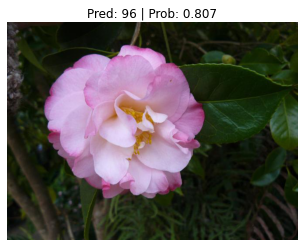

In [ ]:
# Predict on custom image
#updated_pretrained_model
custom_image_path = 'flowers/data/flowers/test/96/image_07622.jpg'
pred_and_plot_image(model=pretrained_model1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=auto_transforms)